In [4]:
import xgboost as xgb
import shap

# Example: Using Iris dataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Save the model
model.save_model('xgb_model.json')


In [5]:
# Dump model with feature maps
model_dump = model.get_booster().get_dump(dump_format='json')
print(model_dump[0])  # Printing only the first tree for brevity


  { "nodeid": 0, "depth": 0, "split": "f2", "split_condition": 2.45000005, "yes": 1, "no": 2, "missing": 1 , "children": [
    { "nodeid": 1, "leaf": 0.426035523 }, 
    { "nodeid": 2, "leaf": -0.218845025 }
  ]}


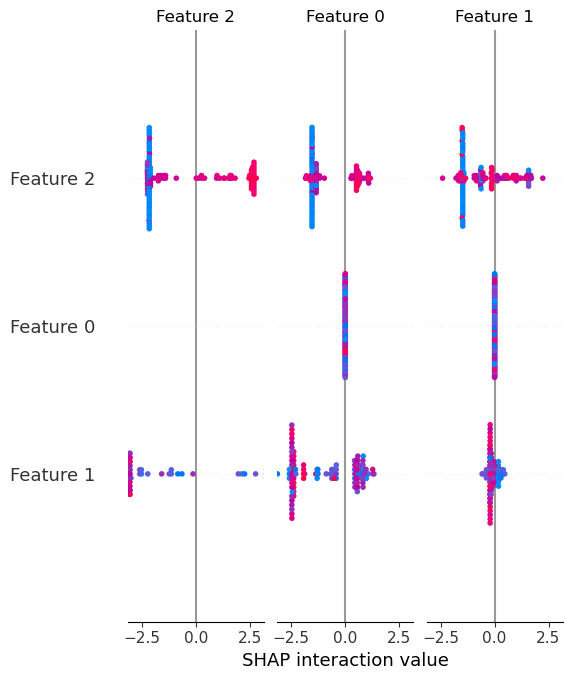

In [6]:
# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Visualize SHAP values for the first prediction
shap.summary_plot(shap_values, X_train, plot_type="bar")


In [7]:
import xgboost as xgb
import shap

# Assuming model is already trained and X_test is your test dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


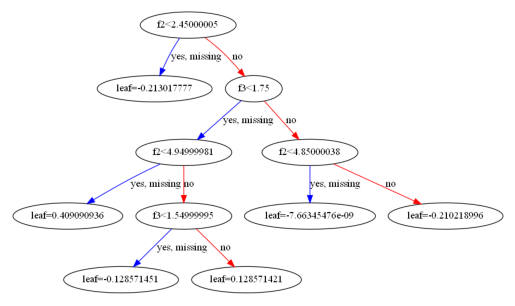

In [15]:
import matplotlib.pyplot as plt

xgb.plot_tree(model, num_trees=1)  # Visualize the first tree
plt.show()


In [16]:
# Get the decision path for the first sample in X_test
booster = model.get_booster()
DMatrix = xgb.DMatrix(X_test)
pred_contribs = booster.predict(DMatrix, pred_contribs=True)

# This returns an array where each row corresponds to a sample,
# and each column corresponds to features, plus a bias term.
# The contributions of each feature sum to the prediction.
print(pred_contribs[0])


[[ 0.          0.         -2.4011893   0.06432801 -0.18214452]
 [ 0.46903855 -0.37334278  1.8275087   0.60073143  0.7143403 ]
 [ 0.53516656  0.2400052  -1.6463957  -1.2142057   0.7486645 ]]


In [18]:
from treeinterpreter import treeinterpreter as ti

# Assuming a decision tree or a simple ensemble model
prediction, bias, contributions = ti.predict(model, data)


AttributeError: 'XGBClassifier' object has no attribute 'n_outputs_'

In [ ]:
xgb_model = xgb.XGBClassifier
xgb_model = xgb.Booster
xgb_model.load_model(booster_file)
xgb_model.feature_names = feature_final


def calculate_data_splits(data, xgb_model):
    trees = xgb_model.get_dump(dump_format='json')
    data = np.array(data, dtype=float)
    data_splits = []

    for tree in trees:
        nodes = json.loads(tree)
        data_indices = np.arange(data.shape[0])

        def tranverse(node, data_indices):
            if 'split' in node:
                feature_name = node['split']
                feature_index = xgb_model.feature_names.index(feature_name)
                threshold = float(node['split_condition'].split('<')[1])
                print(f"Node ID: {node['nodeid']}, feature: {feature_name}, feature_index: {feature_index}, Threshold: {threshold}")
                print(f"Data Shape:{data.shape}, data indices length: {len(data_indices)}")
                left_indices = data_indices[data[:, feature_index]< threshold]
                right_inidces = data_indices[data[:, feature_index]>= threshold]

                total = float(len(data_indices))
                left_prop = len(left_indices) / total
                right_prop = len(right_inidces) /total
                data_splits.append({'node': node['nodeid'],
                                    'feature': feature_index,
                                    'left_prop': left_prop,
                                    'right_prop': right_prop})
                if 'children' in node:
                    for child in node['children']:
                        child_inidces = left_indices if child['nodeid']==node['yes'] else right_inidces
                        tranverse(child, child_inidces)
        tranverse(node, data_indices)
    return data_splits

data_splits = calculate_data_splits(X_benchmark, xgb_model)
print(data_splits)

In [ ]:
def calculate_data_splits(data, xgb_model):
    trees = xgb_model.get_dump(dump_format='json')
    data = np.array(data, dtype=float)
    all_tree_splits = []

    for tree_idx, tree in enumerate(trees):
        nodes = json.loads(tree)
        data_indices = np.arange(data.shape[0])
        tree_splits = []

        def traverse(node, data_indices):
            if 'split' in node:
                feature_name = node['split']
                feature_index = xgb_model.feature_names.index(feature_name)
                threshold = float(node['split_condition'])

                left_indices = data_indices[data[data_indices, feature_index] < threshold]
                right_indices = data_indices[data[data_indices, feature_index] >= threshold]

                if len(left_indices) == 0 or len(right_indices) == 0:
                    return

                tree_splits.append((len(left_indices), len(right_indices)))

                if 'children' in node:
                    for child in node['children']:
                        child_indices = left_indices if child['nodeid'] == node['yes'] else right_indices
                        traverse(child, child_indices)

        traverse(nodes, data_indices)
        
        # Aggregate results per tree
        total_left = sum(split[0] for split in tree_splits)
        total_right = sum(split[1] for split in tree_splits)
        total = total_left + total_right
        all_tree_splits.append({'tree_idx': tree_idx, 
                                'left_prop': total_left / total if total != 0 else 0, 
                                'right_prop': total_right / total if total != 0 else 0})

    return all_tree_splits


In [ ]:
import xgboost as xgb
import numpy as np

# Assuming xgb_model is your trained XGBoost model and X_test is your input features.
# Convert data to DMatrix object, which is optimized for XGBoost.
dtest = xgb.DMatrix(X_test)

# Get the total number of trees built in the model
num_trees = xgb_model.best_ntree_limit  # Or simply use xgb_model.num_boost_round if best_ntree_limit is not set

# Store predictions for each cumulative set of trees
cumulative_predictions = []

for n in range(1, num_trees + 1):
    pred = xgb_model.predict(dtest, ntree_limit=n)
    cumulative_predictions.append(pred)

# cumulative_predictions now contains the predictions with 1 tree, 1+2 trees, ..., up to all trees.
